# Przesukiwanie przestrzeni parametrów stukturalnych modelu za pomocą algorytmu optymalizacji dyskretnej


Dla każdego wejścia modelu `u_{i}` określamy wektor parametrów `(N_{i}, d_{i}, D_{i})`, gdzie:
- `N_{i}` - rząd dynamiki modelu, `N_{i} >= 0`,
- `d_{i}` - opóźnienie wejścia, `d_{i} >= 0`,
- `D_{i}` - rząd nieliniowości wejścia, `D_{i} > 0`

Strukturę modelu danego wyjścia `y_{j}` możemy opisać za pomocą macierzy M

`M = [(N_{1}, d_{1}, D_{1}), (N_{2}, d_{2}, D_{2}), ..., (N_{m}, d_{m}, D_{m})]`

Struktura macierzy M może zostać dobrana w drodze optymalizacji dyskretnej. Dla danej macierzy M' można zidentyfikować parametry dpowiadające modelowi, przy użyciu metody najmniejszych kwadratów.

## Zaimportuj potrzebne biblioteki

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution 

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))

pandas version: 1.0.1
numpy version: 1.18.2
matplotlib version: 3.2.0


## Przygotuj dane uczące i weryfikacyjne


In [2]:
def changeDateToSeconds(df):
    first = df["date"][0]
    df["date"] = df["date"].apply(lambda timestamp: (timestamp-first).seconds)
    return df

def readDataFromExcel(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet)
    df["date"] = pd.to_datetime(df["date"])
    df = changeDateToSeconds(df)
    return df

df_learn = readDataFromExcel("./data/K-1_MI.xlsx", "d2")
df_verif = readDataFromExcel("./data/K-1_MI.xlsx", "d6")

inputs = ["FWF", "PTWT"]
outputs = ["LT01"]

def applyMedianFilter(dataFrame, kernelSize):
    cols = dataFrame.shape[1]
    for col in range(cols):
        dataFrame[:,col] = signal.medfilt(dataFrame[:,col], kernelSize)
    return dataFrame

## Przygotuj macierz A do zadania najmniejszych kwadratów

### Przygotuj wejście i wyjście

In [3]:
def prepareSignals(df, inputs, output, medfilt=False, kernelSize=11):
    inputSignals = df[inputs]
    outputSignal = df[output]
    inputFrame = pd.concat([inputSignals, outputSignal.shift(1)], axis=1).iloc[1:]

    if(medfilt == True):
        u_signals = applyMedianFilter(inputFrame.to_numpy(), kernelSize)
        y_signal = applyMedianFilter(df[output].iloc[1:].to_numpy(), kernelSize)

    else:
        u_signals = inputFrame.to_numpy()
        y_signal =  df[output].iloc[1:].to_numpy()
        
    return (u_signals, y_signal)

### Macierz dla pojedynczego wejścia

In [4]:
def createModelMatrixForSingleInput(data, order, delay, exponent):
    if(order < 0 or delay < 0 or exponent <= 0):
        raise AssertionError("Invalid structure parameter")
        
    samples = data.shape[0]
    widthCoefficient = (order + 1)*exponent
    heightAbsoluteTerm = order + delay
    
    A = np.zeros([samples - heightAbsoluteTerm, widthCoefficient])
    
    for j in range(order+1):
        for k in range(exponent):
            colIndex = (order-j)*exponent + k
            A[:, colIndex] = np.power(data[j : samples-heightAbsoluteTerm+j], k+1)
    
    return A

### Macierz dla wszystkich wejść obiektu

In [5]:
def findMinDelayAndOrder(M):
    minDelay = 1000; minOrder = 1000
    for index, parameters in enumerate(M.T):
        order, delay, exponent = parameters
        if(order < minOrder):
            minOrder = order
        if(delay < minDelay):
            minDelay = delay
    
    return minDelay, minOrder

def findMaxDelayAndOrder(M):
    maxDelay = 0; maxOrder = 0
    for index, parameters in enumerate(M.T):
        order, delay, exponent = parameters
        if(order > maxOrder):
            maxOrder = order
        if(delay > maxDelay):
            maxDelay = delay
    
    return maxDelay, maxOrder

def createModelMatrix(data, M):
    if(M.shape[0] != 3):
        raise AssertionError("Invalid parameter vector size")

    if(M.shape[1] != data.shape[1]):
        raise AssertionError("Mismatched size of data: {} and M: {} vector".format(data.shape, M.shape))
        
    inputs = M.shape[1]
    height = data.shape[0]
    
    maxDelay, maxOrder = findMaxDelayAndOrder(M)
    minDelay, minOrder = findMinDelayAndOrder(M)
    A = np.empty(shape=(height-maxOrder-maxDelay, 0)) 
    for index, parameters in enumerate(M.T):
        # stworz macierz dla danego wejscia
        inputData = data[:, index]
        order, delay, exponent = parameters
        Ap = createModelMatrixForSingleInput(data[:, index], order, delay, exponent)
        
        # obetnij macierz - delay od góry, a order od dołu macierzy
        delayMaxDiff = np.abs(maxDelay-delay)
        orderMaxDiff = np.abs(maxOrder-order)
        baseHeight = Ap.shape[0]
        validA = Ap[orderMaxDiff+delayMaxDiff:]
        validA = validA[:A.shape[0]]
        
        # dodaj do akumulatora
        A = np.concatenate((A, validA), axis=1)
        
    return A

## Optymalizacja dyskretna struktury modelu

### Funkcja celu :: Macierz struktury -> Wynik modelu

In [84]:
def evalModelScore(M, u_learn, y_learn, u_verif, y_verif):
    maxDelay, maxOrder = findMaxDelayAndOrder(M)   

    numberOfSamples = y_learn.shape[0]
    output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
    output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]
    
    A_learn = createModelMatrix(u_learn, M)
    model = linear_model.Ridge(alpha=1.0, normalize=True).fit(A_learn, output_learn_cut)
   
    data_idx = maxOrder+maxDelay+1
    u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
    A_verif = createModelMatrix(u_verif_wip, M)
    for i in range(data_idx, data_idx+len(output_learn_cut)):
        output_model_verif = model.predict(A_verif)
        u_verif_wip = np.concatenate((u_verif_wip, u_verif[data_idx:data_idx+1]), axis=0)
        data_idx += 1
        u_verif_wip[-1][-1] = output_model_verif[-1]
        A_verif = createModelMatrix(u_verif_wip, M) 
        
    output_model_verif = model.predict(A_verif)    
    verif_score = r2_score(output_verif_cut, output_model_verif)

    return model, verif_score

mx = np.transpose(np.array([[0,0,1], [0,0,1]]))
evalModelScore(mx, u_learn, y_learn, u_verif, y_verif)

(Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
       random_state=None, solver='auto', tol=0.001),
 -1.531723165184566)

### Sformułuj zadanie optymalizacji

In [78]:
inputs = ["FWF"]
output = ["LT01"]

u_learn, y_learn = prepareSignals(df_learn, inputs, output, medfilt=True, kernelSize=11)
u_verif, y_verif = prepareSignals(df_verif, inputs, output)

def goalFunction(x):
    # zbuduj macierz M na podstawie wektora x
    M = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
    for index, value in enumerate(x):
        row = index % 3; col = index // 3
        M[row, col] = int(value)
    
    model, score = evalModelScore(M, u_learn, y_learn, u_verif, y_verif)
    return (-1)*score

### Znajdź parametry modelu

In [85]:
bounds = [(0, 10), (0,50), (1, 2)]*(len(inputs) + 1)
result = differential_evolution(goalFunction, bounds, disp=True, polish=False)

differential_evolution step 1: f(x)= -0.128705
differential_evolution step 2: f(x)= -0.134233
differential_evolution step 3: f(x)= -0.13726
differential_evolution step 4: f(x)= -0.157429
differential_evolution step 5: f(x)= -0.157429
differential_evolution step 6: f(x)= -0.174924
differential_evolution step 7: f(x)= -0.249631
differential_evolution step 8: f(x)= -0.249631
differential_evolution step 9: f(x)= -0.271156
differential_evolution step 10: f(x)= -0.271156
differential_evolution step 11: f(x)= -0.271156
differential_evolution step 12: f(x)= -0.271156
differential_evolution step 13: f(x)= -0.271156
differential_evolution step 14: f(x)= -0.271156
differential_evolution step 15: f(x)= -0.271156
differential_evolution step 16: f(x)= -0.271156
differential_evolution step 17: f(x)= -0.271156
differential_evolution step 18: f(x)= -0.271156
differential_evolution step 19: f(x)= -0.271156
differential_evolution step 20: f(x)= -0.271156
differential_evolution step 21: f(x)= -0.271156
di

[[ 5  9]
 [12  5]
 [ 1  1]]
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)
0.2726766249521939


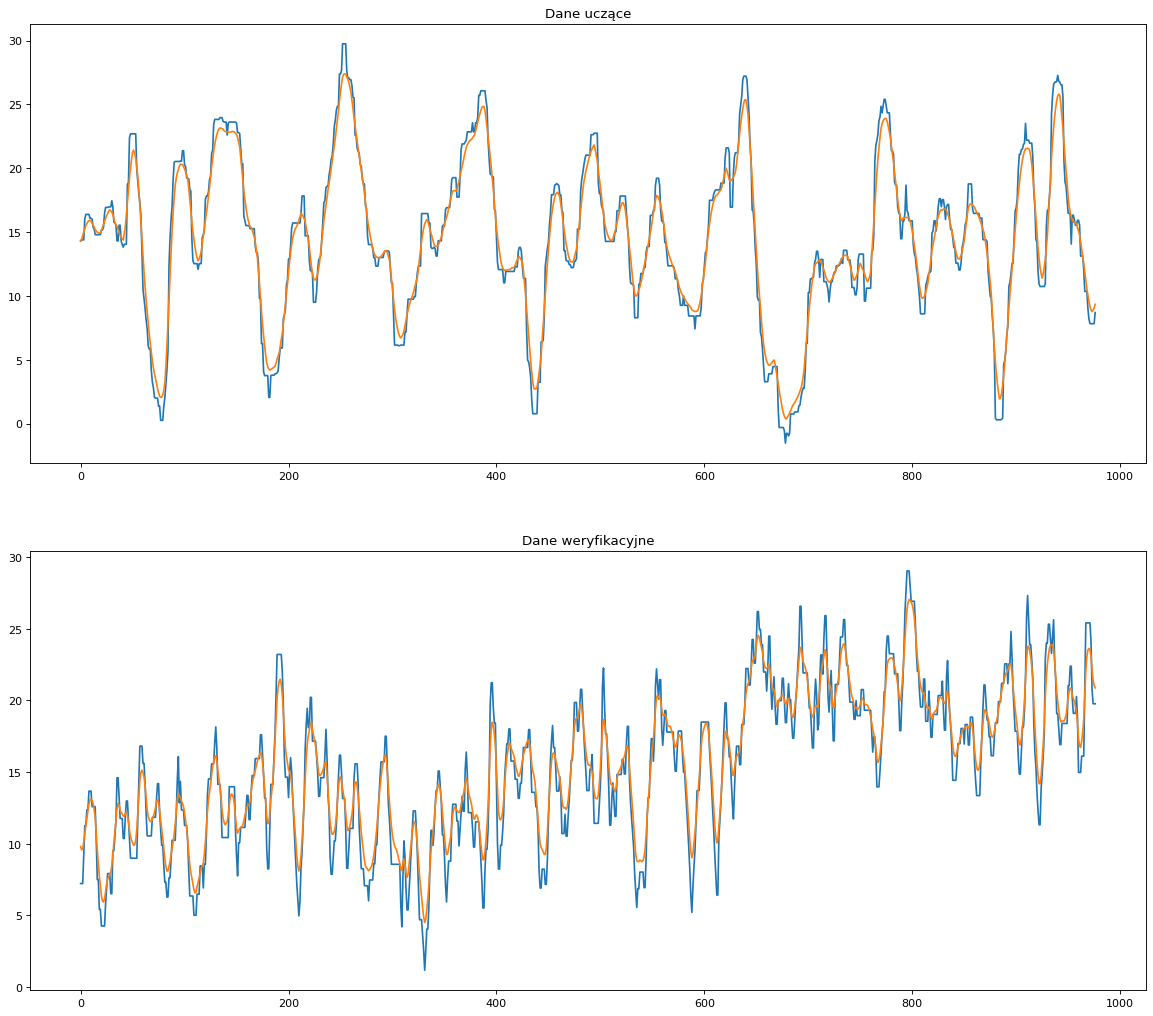

In [89]:
optimM = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
for index, value in enumerate(result.x):
    row = index % 3; col = index // 3
    optimM[row, col] = int(value)
print(optimM)

u_learn, y_learn = prepareSignals(df_learn, inputs, output, medfilt=True, kernelSize=11)
u_verif, y_verif = prepareSignals(df_verif, inputs, output)
model, score = evalModelScore(optimM, u_learn, y_learn, u_verif, y_verif)

print(model)

# A_verif = createModelMatrix(u_verif, optimM)
A_learn = createModelMatrix(u_learn, optimM)
y_model_learn = model.predict(A_learn)
# y_model_verif = model.predict(A_verif)

data_idx = maxOrder+maxDelay+1
u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
A_verif = createModelMatrix(u_verif_wip, optimM)
for i in range(data_idx, data_idx+len(output_learn_cut)):
    output_model_verif = model.predict(A_verif)
    u_verif_wip = np.concatenate((u_verif_wip, u_verif[data_idx:data_idx+1]), axis=0)
    data_idx += 1
    u_verif_wip[-1][-1] = output_model_verif[-1]
    A_verif = createModelMatrix(u_verif_wip, optimM) 
       
output_model_verif = model.predict(A_verif)    
verif_score = r2_score(output_verif_cut, output_model_verif)
print(verif_score)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]

# plot data
fig, axs = plt.subplots(2,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
axs[0].plot(output_learn_cut)
axs[0].plot(y_model_learn)
axs[0].set_title("Dane uczące")
axs[1].plot(output_verif_cut)
axs[1].plot(y_model_verif)
axs[1].set_title("Dane weryfikacyjne")
plt.rcParams['figure.figsize'] = [15, 20]

differential_evolution step 1: f(x)= -0.946372
differential_evolution step 2: f(x)= -0.946372
differential_evolution step 3: f(x)= -0.949348
differential_evolution step 4: f(x)= -0.949348
differential_evolution step 5: f(x)= -0.949348
differential_evolution step 6: f(x)= -0.949348
differential_evolution step 7: f(x)= -0.949348
differential_evolution step 8: f(x)= -0.949348
differential_evolution step 9: f(x)= -0.949348
[[9]
 [4]
 [1]]
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)


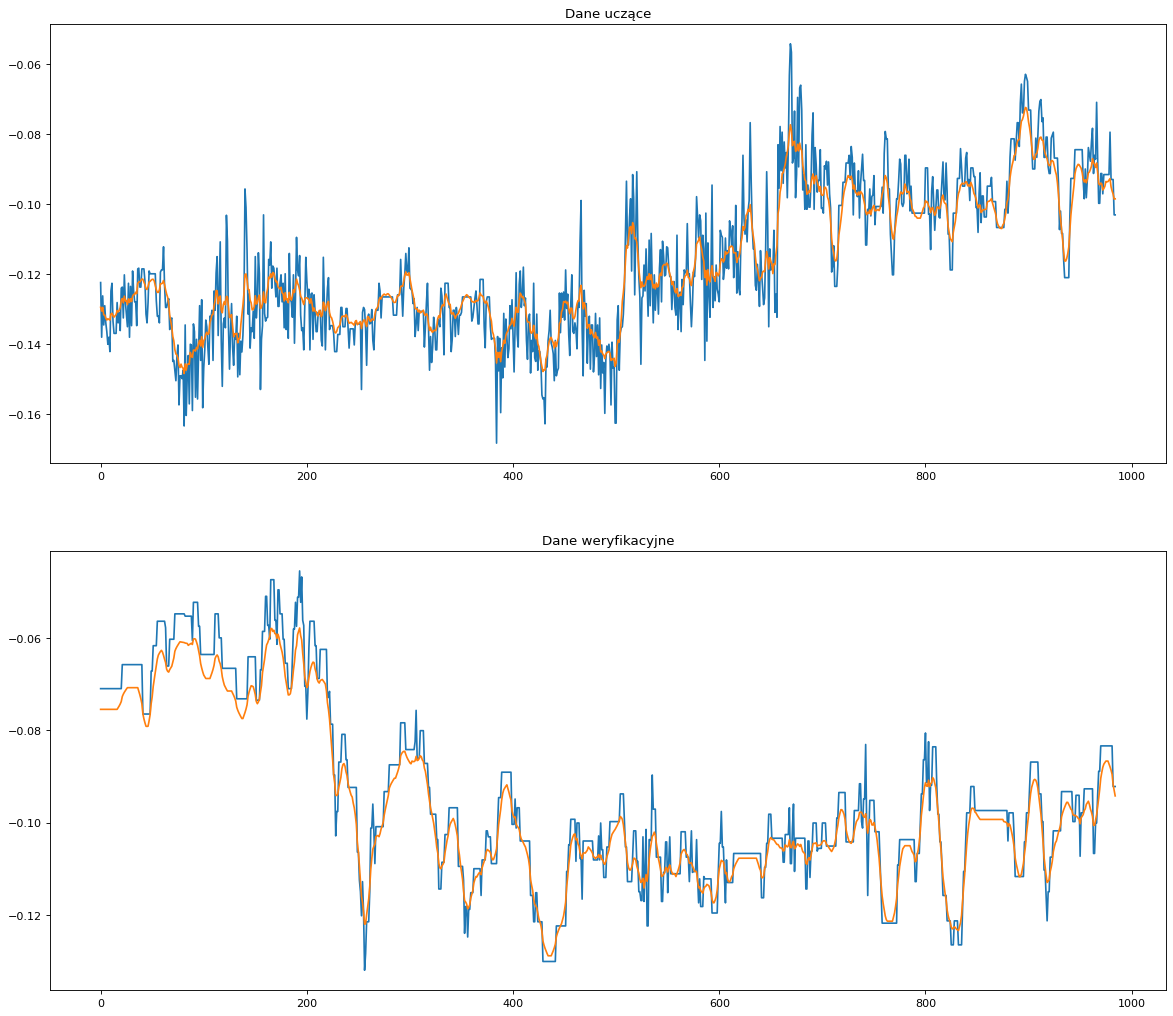

In [10]:
inputs = []
output = ["DP"]

u_learn, y_learn = prepareSignals(df_learn, inputs, output, medfilt=True, kernelSize=11)
u_verif, y_verif = prepareSignals(df_verif, inputs, output)

bounds = [(0, 10), (0,50), (1, 2)]*(len(inputs) + 1)
result = differential_evolution(goalFunction, bounds, disp=True, polish=False)

optimM = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
for index, value in enumerate(result.x):
    row = index % 3; col = index // 3
    optimM[row, col] = int(value)
print(optimM)

u_learn, y_learn = prepareSignals(df_learn, inputs, output)
u_verif, y_verif = prepareSignals(df_verif, inputs, output)
model, score = evalModelScore(optimM, u_learn, y_learn, u_verif, y_verif)

print(model)

A_verif = createModelMatrix(u_verif, optimM)
A_learn = createModelMatrix(u_learn, optimM)
y_model_learn = model.predict(A_learn)
y_model_verif = model.predict(A_verif)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]

# plot data
fig, axs = plt.subplots(2,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
axs[0].plot(output_learn_cut)
axs[0].plot(y_model_learn)
axs[0].set_title("Dane uczące")
axs[1].plot(output_verif_cut)
axs[1].plot(y_model_verif)
axs[1].set_title("Dane weryfikacyjne")
plt.rcParams['figure.figsize'] = [15, 20]